In [ ]:
import os
from brayns import Client
from bioexplorer import BioExplorer, Metabolism
%matplotlib notebook

# URL = 'r1i4n2.bbp.epfl.ch:5000'
URL = 'localhost:5000'

be = BioExplorer(URL)
core = be.core_api()
be.reset_scene()

data_folder = os.getenv('METABOLISM_DATA_FOLDER')

## Data loading

In [ ]:
load_neuron = True
load_astrocyte = True
load_vasculature = True
use_sdf = True

scale = 1.0
scene_center = [-12.288735,1252.127516,465.119185]

In [ ]:
if load_neuron:
    print('Loading neuron')
#     neuron_sql_filter = 'sqrt(pow(x - %f, 2) + pow(y - %f, 2) + pow(z - %f, 2)) < 10' % (scene_center[0], scene_center[1], scene_center[2])
    neuron_sql_filter = 'guid=44127'
    neuron_assembly_name = 'Neuron'
    be.remove_assembly(neuron_assembly_name)
    be.add_assembly(neuron_assembly_name)
    be.add_neurons(
        assembly_name=neuron_assembly_name,
        morphology_color_scheme=be.MORPHOLOGY_COLOR_SCHEME_SECTION,
        population_name='o1',
        use_sdf=use_sdf,
        radius_multiplier=7.0,
        load_somas=True, load_basal_dendrites=True, load_apical_dendrites=True, load_axon=True,
        load_synapses=True,
        generate_internals=True, generate_externals=True, 
        sql_node_filter=neuron_sql_filter, scale=scale)

if load_astrocyte:
    print('Loading astrocytes...')
    astrocytes_sql_filter = 'sqrt(pow(x - %f, 2) + pow(y - %f, 2) + pow(z - %f, 2)) < 25' % (scene_center[0], scene_center[1], scene_center[2])
    assembly_name = 'Astrocytes'
    be.remove_assembly(assembly_name)
    vasculature_assembly = be.add_assembly(assembly_name)
    vasculature_model = be.add_astrocytes(
        assembly_name=assembly_name,
        population_name='o1',
        use_sdf=use_sdf,
        load_somas=True, load_dendrites=True, load_end_feet=True,
        sql_filter=astrocytes_sql_filter, scale=scale)

if load_vasculature:
    vasculature_sql_filter = 'sqrt(pow(x - %f, 2) + pow(y - %f, 2) + pow(z - %f, 2)) < 50' % (scene_center[0], scene_center[1], scene_center[2])
    print('Loading vasculature...')
    assembly_name = 'Vasculature'
    population_name = 'Vasculature'
    be.remove_assembly(assembly_name)
    vasculature_assembly = be.add_assembly(assembly_name)

    vasculature_model = be.add_vasculature(
        assembly_name=assembly_name,
        population_name=population_name,
        quality=be.GEOMETRY_QUALITY_MEDIUM,
        use_sdf=use_sdf,
        radius_multiplier=0.85,
        sql_filter=vasculature_sql_filter, scale=scale)

In [ ]:
def set_metabolism_materials(model_id, color, location_1, location_2, location_3):
    colors = list()
    user_params = list()
    material_ids = be.get_material_ids(model_id)['ids']
    for material_id in material_ids:
        mid = material_id % be.NB_MATERIALS_PER_NEURON
        colors.append(color)
        if mid in [be.NEURON_MATERIAL_AFFERENT_SYNPASE, be.NEURON_MATERIAL_AFFERENT_SYNPASE]: # Synapses
            user_params.append(location_2)
        elif mid == be.NEURON_MATERIAL_MITOCHONDRION: # Mitochondria
            user_params.append(location_3)
        elif mid == be.NEURON_MATERIAL_NUCLEUS: # Mitochondria
            user_params.append(location_3)
        else: 
            user_params.append(location_1)
       
    be.set_materials(
        model_ids=[model_id], material_ids=material_ids,
        diffuse_colors=colors, specular_colors=colors,
        user_parameters=user_params
    )
    
model_ids = be.get_model_ids()['ids']
index = 0
if load_neuron:
    neuron_model_id = model_ids[index]
    set_metabolism_materials(neuron_model_id, [0,1,1], 0, 3, 5)
    index += 1
if load_astrocyte:
    astrocyte_model_id = model_ids[index]
    set_metabolism_materials(astrocyte_model_id, [1,1,0], 1, 1, 6)
    index += 1
if load_vasculature:
    vasculature_model_id = model_ids[index]
    set_metabolism_materials(vasculature_model_id, [1,0,0], 7, 7, 7)

In [ ]:
# core.set_camera(
#     orientation=[-0.5146213415822631, 0.19747553106262067, 0.3559165208061695, 0.7546467515578659],
#     position=[-18.742867239958045, 1308.8065027528064, 498.60411969515536],
#     target=[-13.844808453981072, 1243.001296921148, 470.4582214355469]
# )

In [ ]:
status = core.set_camera(
    orientation=[-0.557022204863438, 0.31489435933184223, 0.31734136010407354, 0.6999016123123016],
    position=[-7.585008861179581, 1313.275510615653, 483.4527388153903],
    target=[-13.844808453981072, 1243.001296921148, 470.4582214355469]
)

# Widgets

In [ ]:
from sqlalchemy import create_engine
from sqlalchemy.orm import Session

db_host = os.getenv('DB_HOST')
db_host = '10.80.7.21'
db_name = os.getenv('DB_NAME')
db_user = os.getenv('DB_USER')
db_password = os.getenv('DB_PASSWORD')
db_schema = 'metabolism'

db_connection_string = 'postgresql+psycopg2://%s:%s@%s:5432/%s' % (db_user, db_password, db_host, db_name)
print('Connection string: ' + db_connection_string + ', schema: ' + db_schema)

generate_snapshot = False
generate_movie = False

<IPython.core.display.Javascript object>


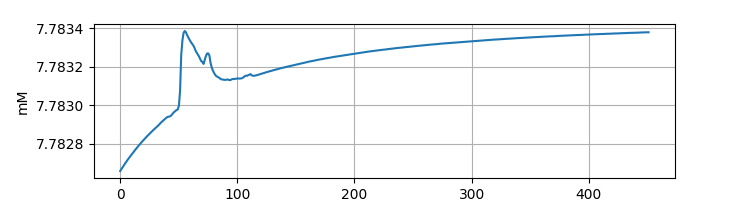

GridspecLayout(children=(Select(description='Location', layout=Layout(grid_area='widget001', height='100px', w…

In [20]:
from bioexplorer import Metabolism

simulation_timestamp = '202111151903'
metabolism = Metabolism(
    be, neuron_model_id, db_host, db_name, db_user, db_password, db_schema,
    simulation_timestamp, relative_concentration=False)
metabolism.display()

In [ ]:
metabolism.set_renderer(
    subsampling=4, max_accum_frames=16, alpha_correction=0.1, 
    noise_frequency=0.0, noise_amplitude=0.1,
    ray_step=3.0, search_length=100.0, use_random_search=False,
    exposure=1.0, far_plane=100.0)

## Snapshot

In [ ]:
def set_neuron_materials(model_id, opacity, color, shading_mode):
    colors = list()
    opacities = list()
    refraction_indices = list()
    specular_exponents = list()
    shading_modes = list()
    user_params = list()
    glossinesses = list()
    emissions = list()
    reflection_indices = list()
    
    material_ids = be.get_material_ids(model_id)['ids']
    print(material_ids)
    for material_id in material_ids:
        mid = material_id % be.NB_MATERIALS_PER_NEURON - 1
        if mid == be.NEURON_MATERIAL_MITOCHONDRION:
            opacities.append(1.0)
            # opacities.append(0.25)
            colors.append([0,0.5,0.5])
            shading_modes.append(be.SHADING_MODE_PERLIN)
            glossinesses.append(0.5)
            user_params.append(1.0 / scale)
            specular_exponents.append(6.0)
            emissions.append(0.5)
            reflection_indices.append(0.0)
        elif mid == be.NEURON_MATERIAL_NUCLEUS:
            opacities.append(1.0)
            colors.append([0.8, 0.9, 0.3])
            shading_modes.append(be.SHADING_MODE_PERLIN)
            glossinesses.append(1.0)
            user_params.append(0.2 / scale)
            specular_exponents.append(30.0)
            emissions.append(0.0)
            reflection_indices.append(0.0)
        elif mid == be.NEURON_MATERIAL_SOMA or mid==be.NEURON_MATERIAL_AXON:
            opacities.append(opacity)
            colors.append(color)
            shading_modes.append(shading_mode)
            glossinesses.append(0.75)
            user_params.append(0.05 / scale)
            specular_exponents.append(5.0)
            emissions.append(0.0)
            reflection_indices.append(0.0)
        elif mid == be.NEURON_MATERIAL_MYELIN_STEATH:
            # opacities.append(0.3)
            opacities.append(1.0)
            colors.append([0.59, 0.82, 0.14])
            shading_modes.append(be.SHADING_MODE_PERLIN)
            glossinesses.append(0.1)
            user_params.append(0.1 / scale)
            specular_exponents.append(5.0)
            emissions.append(0.0)
            reflection_indices.append(0.0)
        else:
            # Membrane
            opacities.append(opacity)
            colors.append(color)
            shading_modes.append(be.SHADING_MODE_PERLIN)
            glossinesses.append(0.7)
            user_params.append(0.02 / scale)
            specular_exponents.append(5.0)
            emissions.append(0.0)
            reflection_indices.append(0.0)
            
        refraction_indices.append(1.2)
        
    be.set_materials(
        model_ids=[model_id], material_ids=material_ids,
        diffuse_colors=colors, specular_colors=colors,
        opacities=opacities, refraction_indices=refraction_indices,
        reflection_indices=reflection_indices,
        shading_modes=shading_modes, specular_exponents=specular_exponents,
        user_parameters=user_params, glossinesses=glossinesses,
        emissions=emissions
    )

def set_astrocyte_materials(model_id, opacity, color, shading_mode):
    colors = list()
    opacities = list()
    refraction_indices = list()
    specular_exponents = list()
    shading_modes = list()
    user_params = list()
    glossinesses = list()
    emissions = list()
    reflection_indices = list()
    
    material_ids = be.get_material_ids(model_id)['ids']
    for material_id in material_ids:
        mid = material_id % be.NB_MATERIALS_PER_ASTROCYTE
        if mid == be.ASTROCYTE_MATERIAL_SOMA:
            # Membrane
            opacities.append(opacity)
            colors.append(color)
            shading_modes.append(shading_mode)
            glossinesses.append(0.1)
            user_params.append(0.1 / scale)
            specular_exponents.append(5.0)
            emissions.append(0.0)
            reflection_indices.append(0.0)
        else:
            # Membrane
            opacities.append(opacity)
            colors.append(color)
            shading_modes.append(be.SHADING_MODE_PERLIN)
            glossinesses.append(0.1)
            user_params.append(0.02 / scale)
            specular_exponents.append(5.0)
            emissions.append(0.0)
            reflection_indices.append(0.0)
            
        refraction_indices.append(1.01)
        
    be.set_materials(
        model_ids=[model_id], material_ids=material_ids,
        diffuse_colors=colors, specular_colors=colors,
        opacities=opacities, refraction_indices=refraction_indices,
        reflection_indices=reflection_indices,
        shading_modes=shading_modes, specular_exponents=specular_exponents,
        user_parameters=user_params, glossinesses=glossinesses,
        emissions=emissions
    )

def set_vasculature_materials(model_id):
    colors = list()
    opacities = list()
    refraction_indices = list()
    specular_exponents = list()
    shading_modes = list()
    user_params = list()
    glossinesses = list()
    
    material_ids = be.get_material_ids(model_id)['ids']
    for _ in material_ids:
        opacities.append(0.5)
        colors.append([1, 0, 0])
        shading_modes.append(be.SHADING_MODE_PERLIN)
        glossinesses.append(0.9)
        user_params.append(0.01 / scale)
        specular_exponents.append(3.0)
        refraction_indices.append(2.5)
        
    be.set_materials(
        model_ids=[model_id], material_ids=material_ids,
        diffuse_colors=colors, specular_colors=colors,
        opacities=opacities, refraction_indices=refraction_indices,
        shading_modes=shading_modes, specular_exponents=specular_exponents,
        user_parameters=user_params, glossinesses=glossinesses
    )

model_ids = be.get_model_ids()['ids']
index = 0
if load_neuron:
    set_neuron_materials(
        model_ids[index], 0.5, [206 / 256, 185 / 256, 135 / 256],
        be.SHADING_MODE_PERLIN)
    index += 1
if load_astrocyte:
    set_astrocyte_materials(
        model_ids[index], 1.0, [206 / 256, 185 / 256, 135 / 256],
        be.SHADING_MODE_PERLIN)
    index += 1
if load_vasculature:
    set_vasculature_materials(model_ids[index])
status = core.set_renderer()

## Media production

In [93]:
from bioexplorer import BioExplorer, MovieMaker

be = BioExplorer(URL)
mm = MovieMaker(be)

### Snapshots

In [ ]:
output_folder = '/gpfs/bbp.cscs.ch/project/proj129/movies/metabolism/2K'

In [ ]:
mm.create_snapshot(
    renderer='bio_explorer',
    size=[1920, 1080], samples_per_pixel=64,
    path=output_folder, base_name='metabolism_bioexplorer_2k_v11')

In [ ]:
mm.create_snapshot(
    renderer='metabolism',
    size=[1920, 1080], samples_per_pixel=16,
    path=output_folder, base_name='metabolism_metabolism_2k_v11')

### Movie

In [92]:
output_folder = '/gpfs/bbp.cscs.ch/project/proj129/movies/metabolism/2K/v11'

In [ ]:
from IPython.display import clear_output
nb_frames = 450
for frame in range(nb_frames):
    clear_output()
    print('Frame %d of %d' % (frame, nb_frames))
    core.set_animation_parameters(current=frame)
    mm.create_snapshot(
        renderer='metabolism',
        size=[1920, 1080], samples_per_pixel=16,
        path=output_folder, base_name='%05d' % frame)

### Metabolites

In [90]:
metabolites = [
    'ATP','ADP','AMP','cAMP','vV0','O2','Glc','Cr','PCr','G1P','G6P',
    'F6P','NAD','NADH','BPG13','PG3','PG2','PEP','Pyr','Lac','Q','QH2',
    'CytCox','CytCred','CoA']

In [94]:
def get_metabolite_guids(metabolite_code):
    db_connection_string = 'postgresql+psycopg2://%s:%s@%s:5432/%s' % (db_user, db_password, db_host, db_name)
    engine = create_engine(db_connection_string)
    with Session(engine) as session:
        data = session.execute("SELECT COUNT(*) FROM %s.location" % db_schema)
        d = data.all()[0]
        nb_locations = int(d[0])
        
        metabolite_ids = list()
        for i in range(nb_locations):
            metabolite_ids.append(-1)
        
        data = session.execute(
            "SELECT v.guid, v.location_guid FROM %s.concentration as c, %s.variable as v "\
            "WHERE c.variable_guid=v.guid and v.code='%s' AND c.frame=0 "\
            "ORDER BY v.location_guid" % (db_schema, db_schema, metabolite_code)) 
        for d in data.all():
            metabolite_ids[d[1]] = d[0]
            
        sql = "SELECT 10 / max(value) FROM %s.concentration WHERE variable_guid IN (" % db_schema
        metabolite_ids_as_string = ''
        for metabolite_id in metabolite_ids:
            if metabolite_id != -1:
                if metabolite_ids_as_string != '':
                    metabolite_ids_as_string += ','
                metabolite_ids_as_string += '%d' % metabolite_id
            
        scale = 1
        if metabolite_ids_as_string != '':
            sql += metabolite_ids_as_string +  ')'
            data = session.execute(sql)
            scale = int('1' + '0'  * len(str(int(data.all()[0][0]))))
        return metabolite_ids, scale

In [95]:
from IPython.display import clear_output
import os

nb_frames = 450
for metabolite in metabolites:
    metabolite_folder = '%s/%s' % (output_folder, metabolite)
    os.mkdir(metabolite_folder)
    metabolite_ids, scale = get_metabolite_guids(metabolite)
    metabolism.set_metabolites(metabolite_ids, scale)
    for frame in range(nb_frames):
        clear_output()
        print('Frame %d of %d' % (frame, nb_frames))
        core.set_animation_parameters(current=frame)
        mm.create_snapshot(
            renderer='metabolism',
            size=[960, 540], samples_per_pixel=16,
            path=metabolite_folder, base_name='%05d' % frame)

Frame 5 of 450


IntProgress(value=0, description='In progress...')

KeyboardInterrupt: 